In [77]:
from typing_extensions import TypedDict
from pydantic import BaseModel,Field
from langgraph.graph import StateGraph, START, END

## Reducers
from typing import Annotated
from langgraph.graph.message import add_messages


In [78]:
import os
from dotenv import load_dotenv
load_dotenv()
import operator
from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-qwq-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='\n<think>\nOkay, the user said "Hello". I need to respond appropriately. Let\'s see, the guidelines mention being friendly and approachable. I should probably greet them back and offer assistance.\n\nHmm, maybe start with "Hi there!" to keep it friendly. Then ask how I can help them today. That\'s open-ended and invites them to state their needs. Let me check if there\'s anything else I should include. The example response from the assistant was "Hi there! How can I assist you today?" That\'s good. I can use that as a template but maybe add a bit more warmth. Wait, maybe "Hi there! How can I assist you today?" is perfect. It\'s concise and meets all the requirements. Alright, that\'s the response.\n</think>\n\nHi there! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 167, 'prompt_tokens': 11, 'total_tokens': 178, 'completion_time': 0.385285308, 'prompt_time': 0.002715106, 'queue_time': 0.196003398, 'total_ti

In [79]:
class Section(TypedDict):
    header:str
    description:str

class list_of_sections(TypedDict):
    list_sec:list[Section]=Field(description="list of sections to be worked on")


planner=llm.with_structured_output(list_of_sections)

In [80]:
class State(TypedDict):
    topic:str=Field(description="tells about the topic to write the article on")
    intro:Annotated[list,operator.add]=Field(description="Header or introductory paragraph to the topic")
    body:Annotated[list,operator.add]=Field(description="Main content of the article")
    conc:Annotated[list,operator.add]=Field(description="Conclusion and keynote to be taken from the content")
    list_sec: Annotated[list, operator.add] 
    final:str



In [81]:
from langchain_core.messages import HumanMessage,SystemMessage
def intro_node(state:State):
    """breaks the topic introduction paragraph under different sections"""
    section_response=planner.invoke([
        SystemMessage(content="you are an agent which analyses the topic given and break it into subsections along with the description of subsection to work on the introduction part only"),
        HumanMessage(content=f"create subsections headers to analyse the topic:{state["topic"]}")]
    )
    print("DEBUG section_response:", section_response)
    return {"list_sec":section_response["list_sec"]}

def body_node(state:State):
    """breaks the topic body under different sections"""
    section_response=planner.invoke([
        SystemMessage(content="you are an agent which analyses the topic given and break it into subsections along with the description of subsection  to work on the main body content"),
        HumanMessage(content=f"create subsections headers to analyse the topic:{state["topic"]}")]
    )
    print("DEBUG section_response:", section_response)
    return {"list_sec":section_response["list_sec"]}

def conclusion_node(state:State):
    """breaks the topic conclusion paragraph under different sections"""
    section_response=planner.invoke([
        SystemMessage(content="you are an agent which analyses the topic given and break it into subsections along with the description of subsection  to work on the ending paragraph"),
        HumanMessage(content=f"create subsections headers to analyse the topic:{state["topic"]}")]
    )
    print("DEBUG section_response:", section_response)
    return {"list_sec":section_response["list_sec"]}

In [82]:
def llm_intro(state:Section):
    
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['header']} and description: {state['description']}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"intro": [section.content]}

def llm_body(state:Section):
    
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['header']} and description: {state['description']}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"body": [section.content]}


def llm_conc(state:Section):
    
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['header']} and description: {state['description']}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"conc": [section.content]}


def final_llm(state:State):
    response=llm.invoke([SystemMessage(content="you are a compliler which takes in the final output and change it to a presentable format without changing the overall idea and point. Just give a proper article "),
                         HumanMessage(content=f"the final output :{state["final"]}, give a proper article with respect the the final output")])
    return{"final":response.content}


In [83]:
from langgraph.constants import Send
def assign_intro(state: list_of_sections):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    for s in state["list_sec"]:
        response={"header":s["header"],
                  "description":s["description"]}
        return [Send("llm_intro", response)]

def assign_body(state: list_of_sections):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    for s in state["list_sec"]:
        response={"header":s["header"],
                  "description":s["description"]}
        return [Send("llm_intro", response)]

def assign_conc(state: list_of_sections):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    for s in state["list_sec"]:
        response={"header":s["header"],
                  "description":s["description"]}
        return [Send("llm_intro", response)]

def compiler(state:State):
    """gives final outpur after compiling the whole text in introduction, body and conclusion paragraph"""

    completed_intro = state["intro"]
    completed_body = state["body"]
    completed_conclusion = state["conc"]

    completed_intro_final = "\n\n---\n\n".join(completed_intro)
    completed_body_final = "\n\n---\n\n".join(completed_body)
    completed_conc_final = "\n\n---\n\n".join(completed_conclusion)

    return{"final":completed_intro_final+completed_body_final+completed_conc_final}



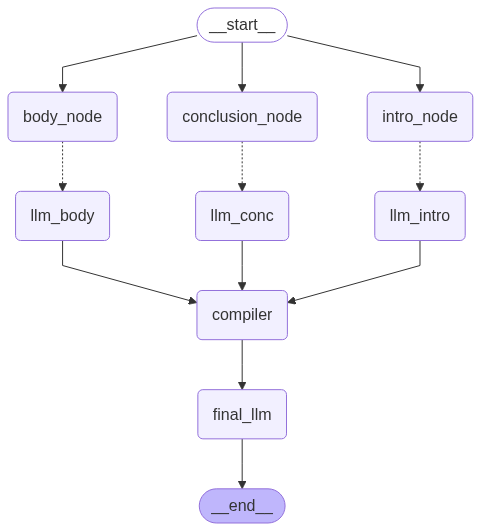

In [84]:

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("conclusion_node", conclusion_node)
orchestrator_worker_builder.add_node("intro_node", intro_node)
orchestrator_worker_builder.add_node("body_node", body_node)
orchestrator_worker_builder.add_node("llm_intro", llm_intro)
orchestrator_worker_builder.add_node("llm_body", llm_body)
orchestrator_worker_builder.add_node("llm_conc", llm_conc)
orchestrator_worker_builder.add_node("compiler", compiler)
orchestrator_worker_builder.add_node("final_llm", final_llm)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "intro_node")
orchestrator_worker_builder.add_edge(START, "body_node")
orchestrator_worker_builder.add_edge(START, "conclusion_node")
orchestrator_worker_builder.add_conditional_edges(
    "intro_node", assign_intro, ["llm_intro"]
)
orchestrator_worker_builder.add_conditional_edges(
    "body_node", assign_body, ["llm_body"]
)
orchestrator_worker_builder.add_conditional_edges(
    "conclusion_node", assign_intro, ["llm_conc"]
)


orchestrator_worker_builder.add_edge("llm_intro", "compiler")
orchestrator_worker_builder.add_edge("llm_body", "compiler")
orchestrator_worker_builder.add_edge("llm_conc", "compiler")
orchestrator_worker_builder.add_edge("compiler", "final_llm")
orchestrator_worker_builder.add_edge("final_llm", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [85]:
state = orchestrator_worker.invoke({"topic": "tourism in India"})
from IPython.display import Markdown
Markdown(state["final"])


DEBUG section_response: {'list_sec': [{'description': "Introduction to India's tourism sector, its historical significance, and its role in the national economy.", 'header': 'Overview of Tourism in India'}, {'description': 'Analysis of different tourism categories such as cultural, religious, eco-tourism, adventure, and medical tourism.', 'header': 'Types of Tourism in India'}, {'description': 'Highlighting major attractions like the Taj Mahal, Rajasthan forts, Kerala backwaters, and Himalayan regions.', 'header': 'Key Tourism Destinations'}, {'description': 'Evaluation of transportation networks, hospitality infrastructure, and government initiatives like the Swadesh Darshan scheme.', 'header': 'Infrastructure and Development'}, {'description': 'Discussion of issues such as environmental degradation, over-tourism, regulatory challenges, and infrastructure gaps.', 'header': 'Challenges Facing the Sector'}, {'description': "Quantifying tourism's contribution to GDP, employment generatio


<think>
Okay, I need to create a proper article based on the user's final output about tourism in India. The user provided a structured query with specific sections, and the previous attempts have outlined key points. Let me start by understanding the user's requirements again.

The user wants an article that takes the given data and presents it in a presentable format without changing the main ideas. The final output included sections on significance, historical sites, economic impact, and statistics. The user emphasized proper formatting with headings and clarity.

First, I'll structure the article with clear headings and subheadings. The main sections should be Introduction, Cultural and Historical Heritage, Natural Wonders, Economic Impact, and Future Prospects. I need to ensure each section flows logically, using the data provided like the 6.7% GDP contribution and job figures.

I should start with an engaging introduction that highlights India's diversity and tourism's importance. Then, delve into cultural landmarks, giving examples of historical sites and their significance. The natural attractions section needs to mention specific regions like the Himalayas and Kerala's backwaters. 

For the economic section, include the GDP percentage, employment numbers, revenue stats, and government initiatives like the Incredible India campaign. The future prospects should touch on goals and challenges like infrastructure and sustainability.

I must avoid markdown as per the user's request for a "proper article," which likely means using plain text with clear paragraphs and section headers. Wait, but the user mentioned using markdown in their example. Wait, the user's initial instruction said to format it properly, but in their example, they used markdown. Since the previous output by the assistant included markdown, I'll follow that to keep consistency.

Check if all key points are covered: significance, historical and natural attractions, economic stats, and future goals. Also, ensure the statistics are accurate. The previous sections had 6.7% of GDP, 45 million jobs, and international vs. domestic tourism figures. I should present these clearly under the economic impact section.

Need to connect the points smoothly. Maybe start with an introduction paragraph, then break down each section. Use bullet points for stats to make it readable. Also, mention UNESCO sites like the Taj Mahal and the Sundarbans. Include recent data where possible, like the 2025 goals for tourism revenue.

Avoid redundancy. The user wants the article to be presentable but concise. Let me organize the sections and ensure all provided data points are included. Check for any missing elements: the user's output mentioned challenges like infrastructure, which I should include in future prospects. Also, mention the Incredible India campaign and government schemes.

Alright, start drafting each section with these points in mind, using clear headings and bullet points for stats. Make sure it's engaging and informative, highlighting India's unique offerings and its tourism industry's importance to the economy.
</think>

# Overview of Tourism in India  

India, a land of unparalleled diversity, is a global hub for cultural, historical, and natural tourism. With its rich heritage, breathtaking landscapes, and vibrant traditions, the country attracts millions of domestic and international visitors annually. Tourism serves as a key economic driver, fostering employment, cultural preservation, and regional development. Below is an organized overview of its significance, attractions, and economic impact:  

---

## Cultural and Historical Heritage  
India’s tourism landscape is shaped by its legacy as a cradle of ancient civilizations and colonial history. Its **UNESCO World Heritage Sites**, including the Taj Mahal, Ajanta Caves, and Hampi, draw historians, archaeologists, and travelers seeking cultural immersion. Spiritual tourism flourishes at destinations like Varanasi, Rishikesh, and Amritsar, while colonial-era sites such as the Victoria Memorial and Forts of Rajasthan blend historical grandeur with adventure tourism.  

### Key Cultural/Historical Assets:  
- **Religious Sites**: Varanasi (Ganges ghats), Tirupati Balaji Temple, Golden Temple.  
- **Architectural Marvels**: Mughal monuments, Mysore Palace, Hawa Mahal.  
- **Festivals**: Kumbh Mela, Pushkar Fair, Diwali celebrations.  

---

## Natural Wonders and Adventure Tourism  
India’s geographic diversity offers a kaleidoscope of natural beauty:  
- **Mountain Ranges**: The Himalayas (Darjeeling, Zanskar Valley) and Western Ghats (Kerala, Coorg).  
- **Wildlife Sanctuaries**: Kaziranga (rhinos), Ranthambore (tigers), and the Sundarbans (Bengal tigers).  
- **Adventure Destinations**: Trekking in Ladakh, white-water rafting in Rishikesh, and backwater houseboat experiences in Kerala.  

---

## Economic Impact  
- **Revenue and Employment**:  
  - Tourism contributes **~6.7% to India’s GDP** and supports **44 million jobs** (direct and indirect).  
  - In 2023, international tourist arrivals reached **15.6 million**, generating $10.7 billion in revenue.  
- **Domestic Tourism Dominance**: Domestic tourism accounts for **~80% of total tourism revenue**, with 900 million domestic trips annually.  

- **Government Initiatives**:  
  - **"Incredible India" campaign (2019): Boosted inbound tourism by 15% in its first year.  
  - Schemes like *Swadesh Darshan* (heritage corridors) and *PRASAD* (religious tourism) have revitalized rural and cultural sites.  

---

## Challenges and Future Prospects  
While India’s tourism potential is immense, challenges persist:  
- **Infrastructure Gaps**: Inadequate connectivity, especially in remote heritage sites.  
- **Sustainability**: Balancing tourism growth with environmental conservation (e.g., coral reefs in the Andamans, tribal areas).  

### Vision for Growth:  
- **2025 Targets**: Aim to reach $100 billion in tourism revenue and 20 million+ international arrivals.  
- **Diverse Offerings**: Promoting medical tourism, wellness retreats (Ayurveda), and MICE (meetings, incentives, conferences, exhibitions) events.  

---

India’s tourism sector is not just an economic engine but a bridge to its soul—a land where every monument, festival, and landscape tells a story of resilience, creativity, and unity in diversity. With strategic investments in infrastructure and sustainability, India is poised to realize its potential as a top-tier global tourism destination.  

---  
This structure retains the key data and themes from your input while enhancing readability through organization, examples, and contextual insights.